In [1]:
dataset <- "ARPAM"
state <- "Marche"
match_dist <- 15000
new_dataset <- "MAR"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [4]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    filter(!(state %in% c("Emilia-Romagna", "Toscana", "Umbria", "Abruzzo", "Lazio"))) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = 10000) |>
    st_drop_geometry()

metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA", "ISAC"), "qc1", conns$data, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(0L))
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))


In [5]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("tag_"), starts_with("user_code"), starts_with("series_id"))


In [23]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(
    gs$table,
    metadata |> mutate(network_prio = if_else(network == "ISAC", 2L, 1L)),
    c("SCIA", "ARPAM", "ISAC"),
    desc(dataset), desc(sensor_last)
)
ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 20L, 0.5, ignore_corrections)


In [24]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>


In [25]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 100, ignore_corrections, contribution_threshold = -1L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations, gs$table)
rm(merge_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2416718,129.1,5197281,277.6,NA,5197281,277.6
Vcells,24830383,189.5,77082596,588.1,16384,120429867,918.9


In [5]:
db$meta |> arrange(sensor_key) |> collect()

sensor_key,sensor_id,station_key,station_id,name,network,town,province_full,province_code,state,...,elevation,elevation_glo30,series_id,dataset,from_sensor_keys,from_datasets,series_first,series_last,valid_days,valid90
<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<dbl>,<chr>,<chr>,<list>,<list>,<date>,<date>,<int>,<int>
1,NA,4,11,Abbadia di Fiastra,RT,NA,Macerata,MC,Marche,...,144.00,240.547592,3396,MAR,"1, 1311","ARPAM, ISAC",2023-01-06,2024-01-16,375,375
6,NA,156,2300,Amatrice,RM,NA,Rieti,RI,Lazio,...,955.00,979.261475,2724,MAR,6,ARPAM,1957-01-01,2013-07-01,19501,7858
7,NA,99,703,Amatrice,RT,NA,Ancona,AN,Marche,...,954.00,55.264751,2958,MAR,7,ARPAM,2013-10-03,2024-01-16,3741,3741
18,NA,122,729,Astorara,RT,NA,Ascoli Piceno,AP,Marche,...,1015.00,1215.542725,3284,MAR,18,ARPAM,2019-11-12,2024-01-16,1515,1515
22,NA,118,724,Bocca Serriola,RT,NA,Perugia,PG,Umbria,...,730.00,638.748657,3028,MAR,"22, 368","ARPAM, ISAC",2014-09-30,2024-01-16,3358,3358
25,NA,65,352,Cagli Civita,RT,NA,Pesaro E Urbino,PU,Marche,...,251.00,555.276672,3252,MAR,"25, 498","ARPAM, ISAC",2018-11-13,2023-12-31,1875,1875
26,NA,130,740,Caldarola,RT,NA,Macerata,MC,Marche,...,295.00,444.630829,3455,MAR,26,ARPAM,2023-06-08,2024-01-16,223,223
31,NA,127,735,Candelara,RT,NA,Pesaro E Urbino,PU,Marche,...,200.00,95.283157,3328,MAR,31,ARPAM,2022-07-19,2023-12-31,480,480
62,NA,53,191,Gualdo,RT,NA,Macerata,MC,Marche,...,1000.00,795.010132,3152,MAR,"62, 1585","ARPAM, ISAC",2017-07-19,2024-01-16,2372,2372


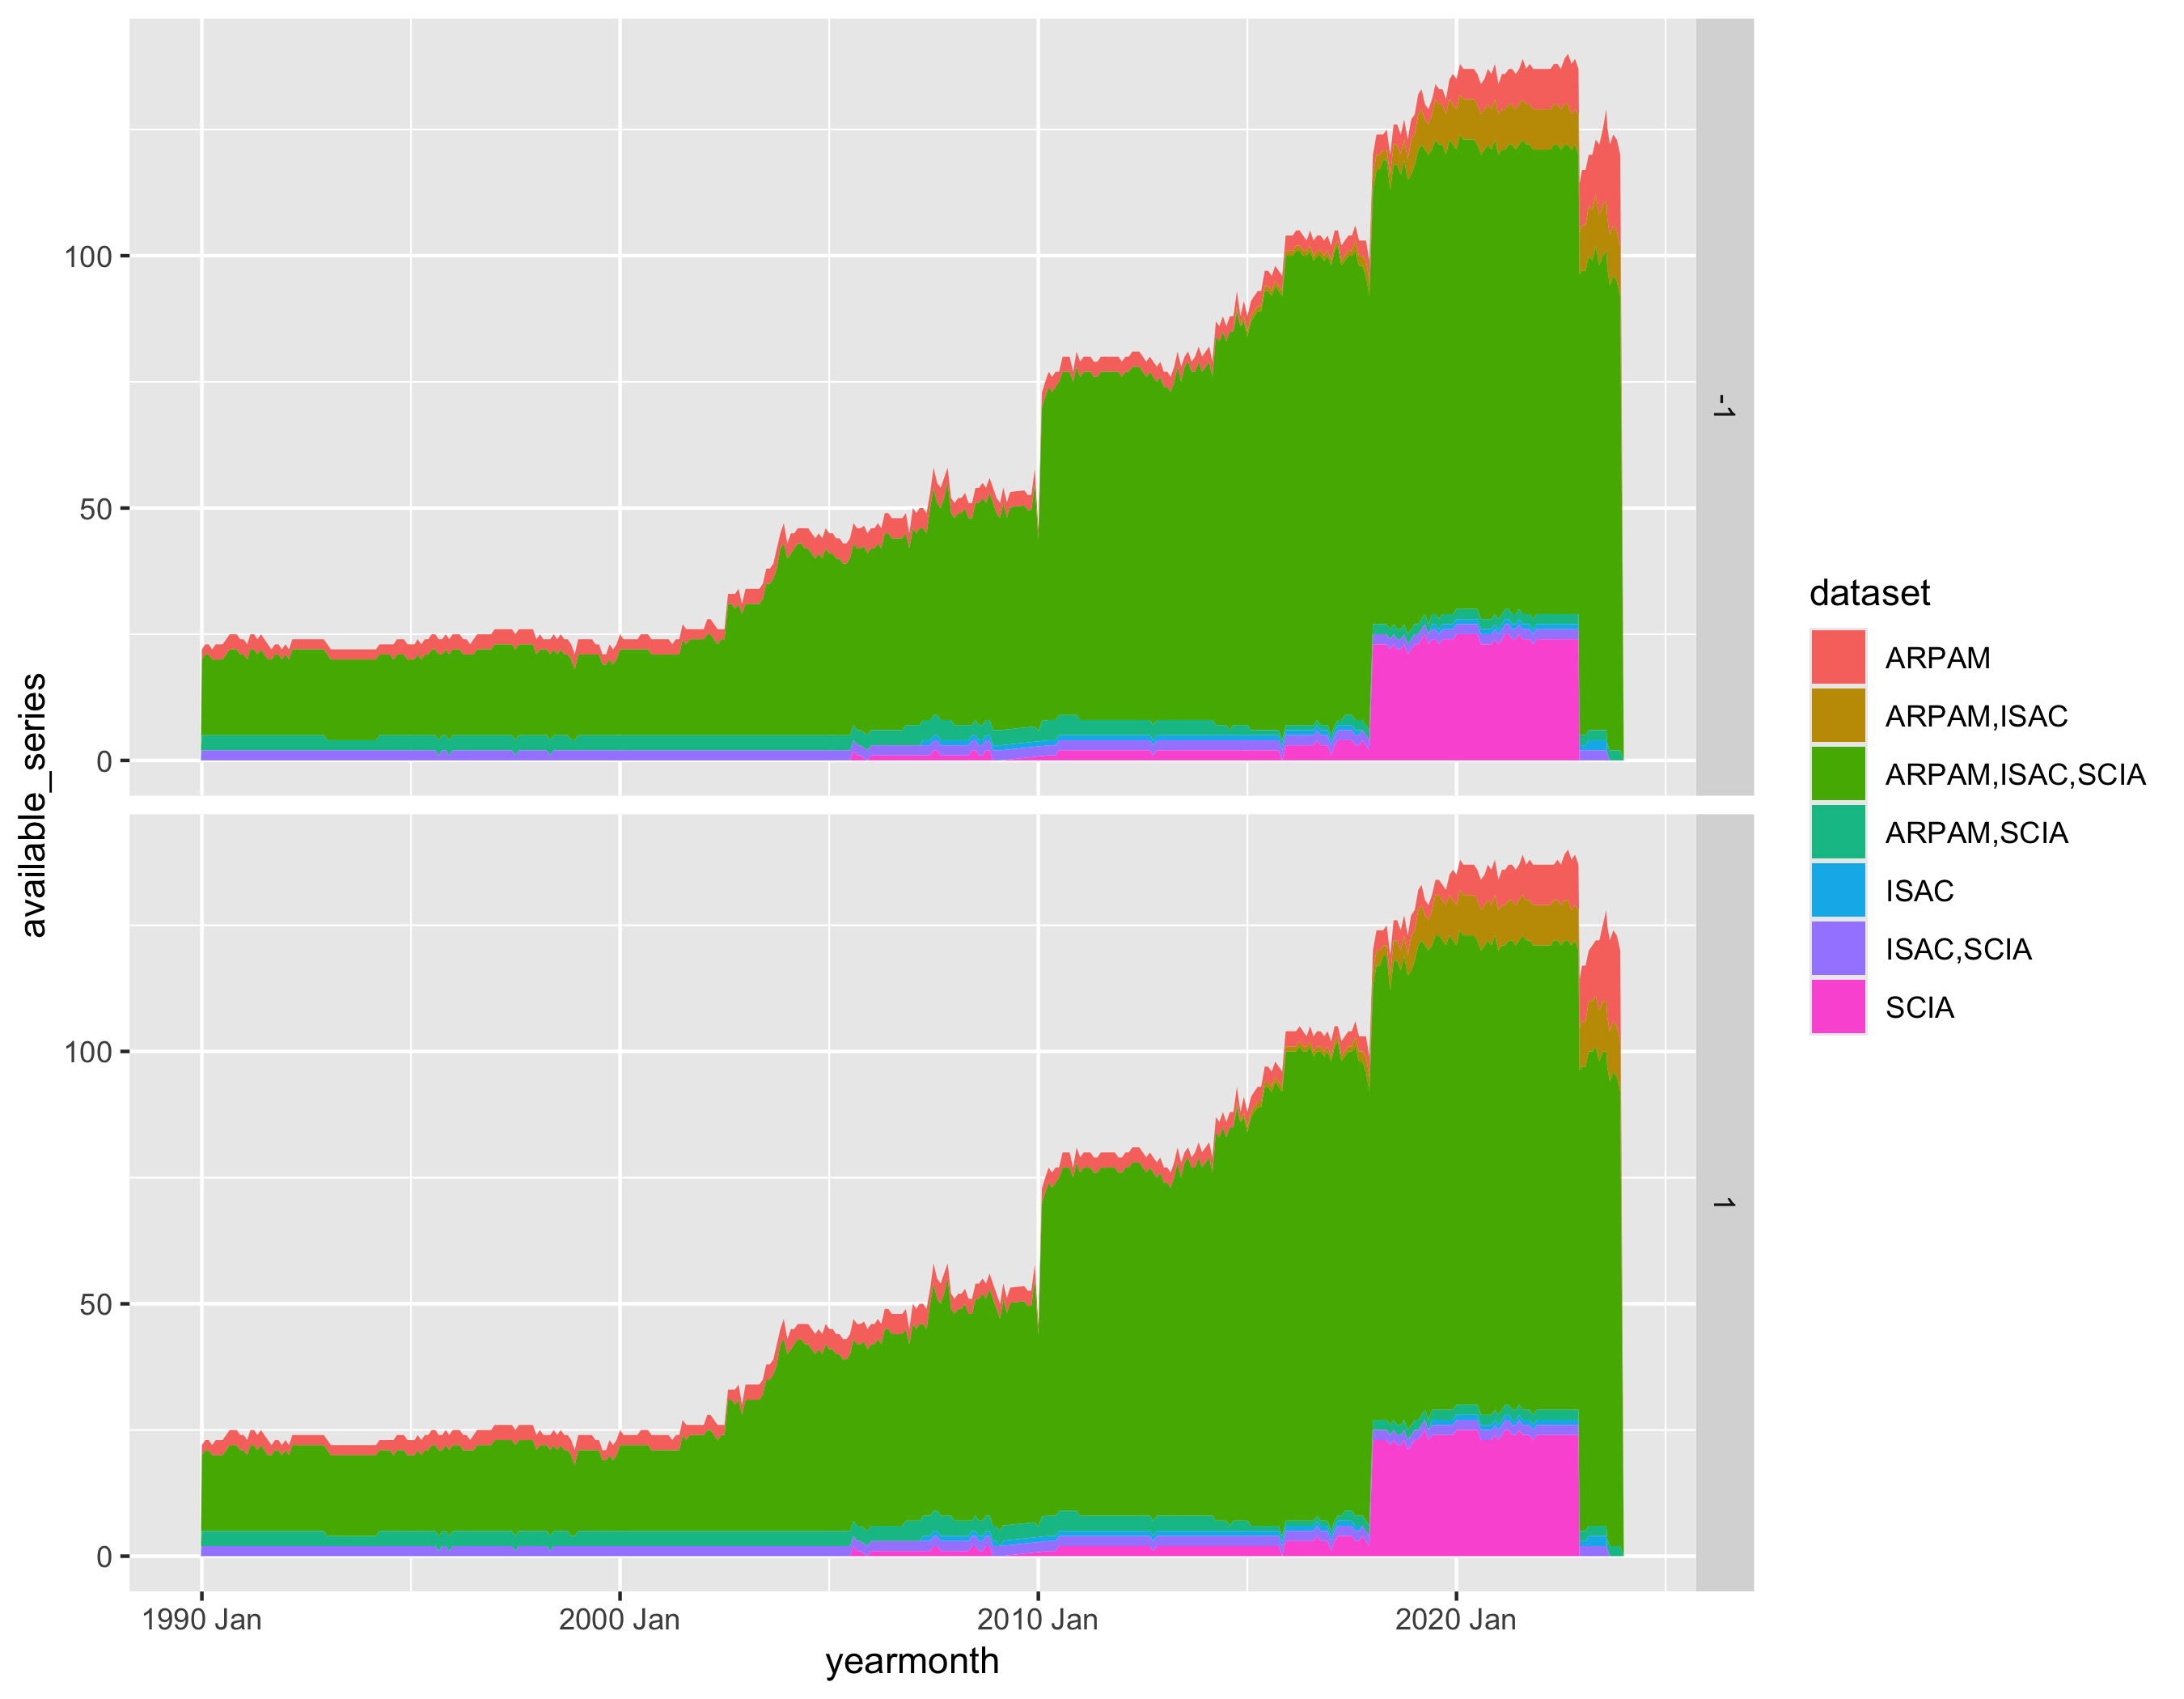

In [3]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


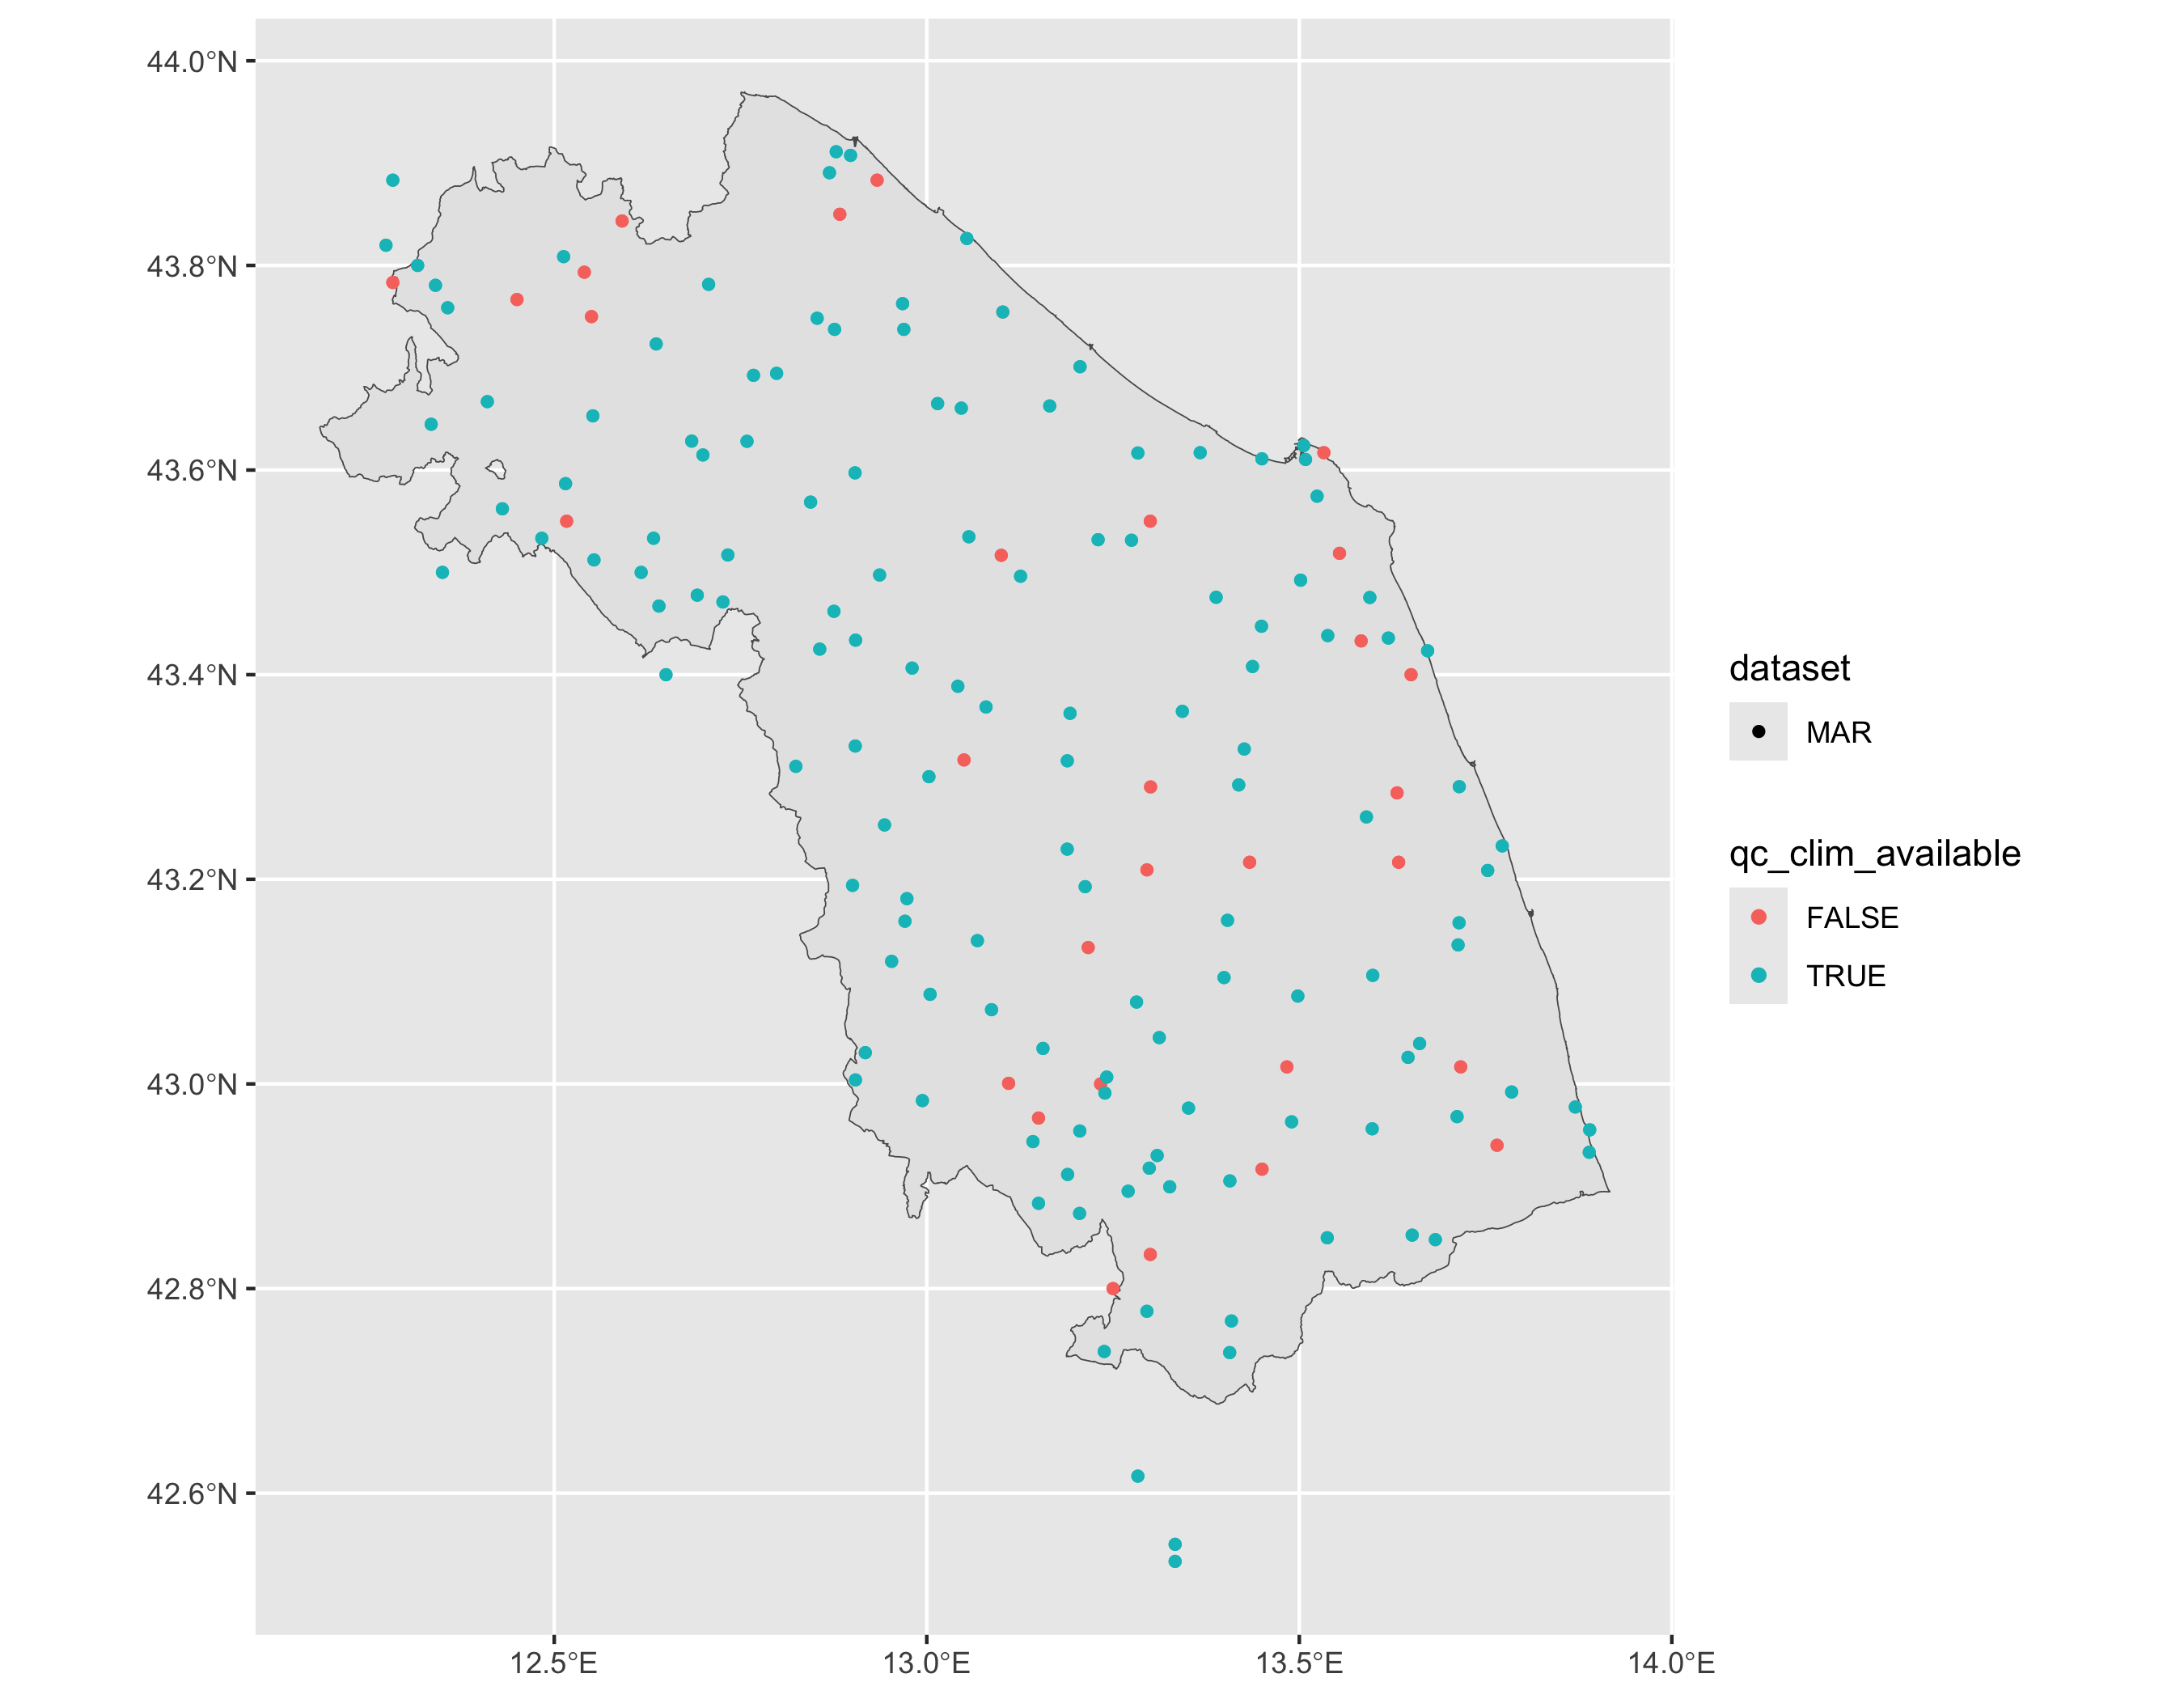

In [34]:
sp_data <- pd[[2]] |> mutate(dataset = new_dataset)
pd <- spatial_availabilities(sp_data, db$meta, state_boundaries, n_years_threshold = 5L)
pd$plot

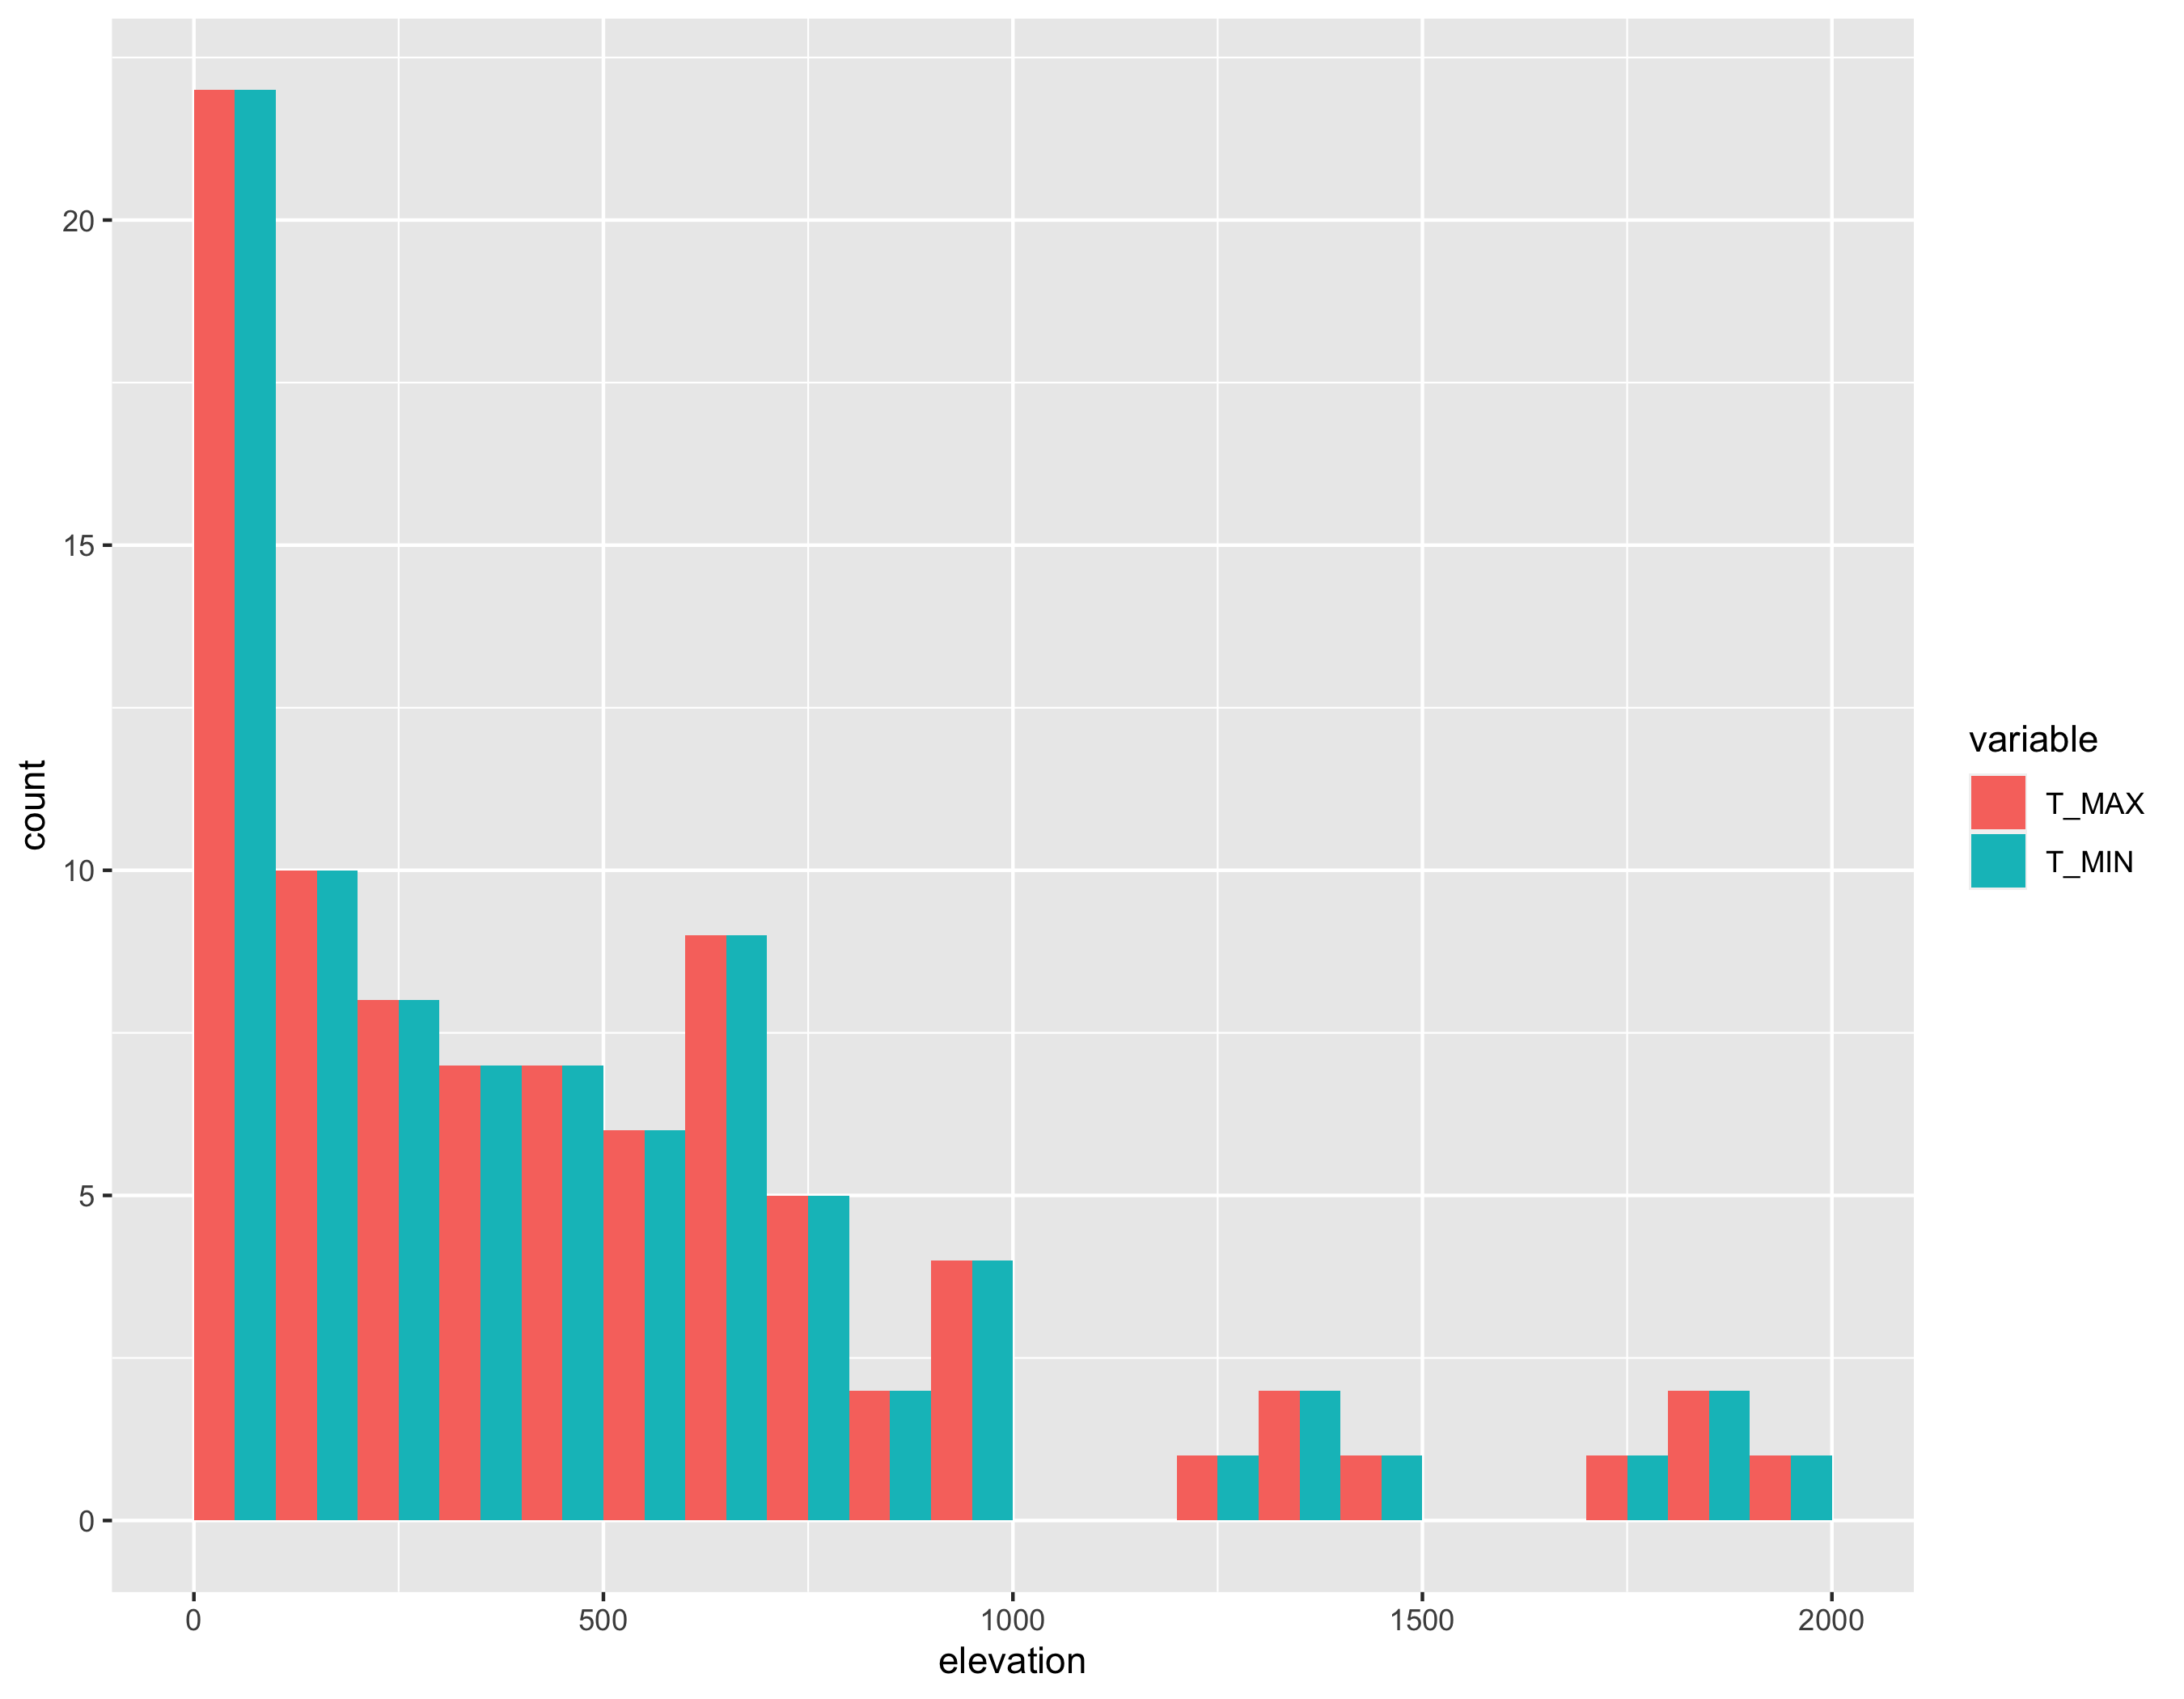

In [13]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())
